# Analysis 

Now that I've validated and cleaned up my dataset, I can analyze it. I'll quickly run everything I did in the [preparation and validation notebook](https://github.com/anushadatar/split-ticket/blob/master/Prepare-Dataset.ipynb) and then go on to actually explore split-ticket voting.

# Setup

In [4]:
from pandas.api.types import is_numeric_dtype
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'


def sanitize_series(series):
    """
    Turns missing data codes in Pandas series into NaN, and then returns 
    the pandas series.
    """
    return series.map(lambda n: n if (n > 0) else np.nan)

def sanitize_df(df):
    """
    Turns missing data codes in Pandas series into NaN, and then returns 
    the pandas series.
    """
    return df.applymap(lambda n: np.nan if (is_numeric_dtype(type(n)) and n < 0) else n)

# Load the dataset.
data_path = "C:/Users/anush/OneDrive/Documents/anes_data/anes_timeseries_cdf_dta/anes.csv"
anes = pd.read_csv(data_path)

# Clean up missing data codes.
anes = sanitize_df(anes)

# Resample.
n = len(anes)
weights = anes['VCF0009z']
sample = anes.sample(n, 
                     replace=True, 
                     weights=weights)


Now that I have a sanitized, resampled dataset, I need to address the first question my dataset can answer: how has the prevalence of split ticket voting changed over time?

# Split Ticket Metrics
The dataset provides a metric for split-ticketedness, but it only looks at the difference between presidential and house votes. This is limiting because it does not consider the Senate and by virtue of considering presidential choices each time it cuts the amount of years in half.

In a general election year, the following outcomes are possible:

Note D stands for Democrat, R for Republican, and I for Independent. There is no data for indpendent house or senate candidates. 

| President | Senate | House |
|-----------|--------|-------|
| R         | R      | R     |
| R         | R      | D     |
| R         | D      | R     |
| R         | D      | D     |
| D         | R      | R     |
| D         | R      | D     |
| D         | D      | R     |
| D         | D      | D     |
| I         | R      | D     |
| I         | R      | D     |
| I         | D      | R     |
| I         | D      | D     |

In a midterm election year, the following outcomes are possible:
Note D stands for Democrat, R for Republican, and I for Independent. There is no data for indpendent house or senate candidates. 

| Senate | House |
|--------|-------|
| R      | R     |
| R      | D     |
| D      | R     |
| D      | D     |


## Metric Specification

The metric I propose to use is a weighted sum of the split-ticketedness of each vote. 

The way I will measure that will be to assign each set of votes a score between 0 and 1. In doing so, I will ignore the independent candidates, which I can justify because while independent candidates generally align with the voters of a single party, there is no straightforward way to determine which independent candidate a survey participant voted for and how that aligns with the rest of their ballot.

The updated metric will work as such:

| President | Senate | House | Score |
|-----------|--------|-------|-------|
| R         | R      | R     | 1     |
| R         | R      | D     | .66   |
| R         | D      | R     | .33   |
| R         | D      | D     | 0     | 
| D         | R      | R     | .66   |
| D         | R      | D     | .33   |
| D         | D      | R     | .33   |
| D         | D      | D     | 0     |
| I         | R      | D     | .5    |
| I         | R      | D     | .5    |
| I         | D      | R     | .5    |
| I         | D      | D     | 1     |


| Senate | House | Score |
|--------|-------|-------|
| R      | R     | 1     |
| R      | D     | .5    |
| D      | R     | .5    |
| D      | D     | 1     |

From there, I can assing a degree of splitness to each person as such.

| Score | Description    |
|-------|----------------|
| 0     | Democrat       |    
| 1     | Republican     |    
| 0.33  | Lean Democrat  | 
| 0.66  | Lean Republican|   
| 0.5   | 50/50 Split    | 

This way, any score greater than or equal to 3 is split.

## Metric calculation
To calculate this metric, I can map each vote to 0 or 1 (or NAN, if independent) and take the average of all of the votes and then remap it to an integer score.

In [5]:

pres_vote = anes["VCF0706"]
house_vote = anes["VCF0707"]
senate_vote = anes["VCF0708"]

# Create new columns with re-mapped values.
anes['pres_vote_ints'] = pres_vote.map({'2. Republican': 1, '1. Democrat': 0, '3. Other (incl. 3d/minor party candidates and write-ins)': np.nan, '7. Did not vote or voted but not for president (exc.1972)': np.nan})
anes['house_vote_ints'] = house_vote.map({'2. Republican': 1, '1. Democrat': 0})
anes['senate_vote_ints'] = senate_vote.map({'2. Republican': 1, '1. Democrat': 0})

In [6]:
# mean() ignores missing values by default, so we can just take the average.
means = anes[['pres_vote_ints', 'house_vote_ints', 'senate_vote_ints']].mean(axis=1).round(3)
# Had to be very specific re: precision here.
anes['split'] = means.map({0.000: 'Democratic Ballot', 
                         1.000: 'Republican Ballot', 
                         0.333: 'Democratic-Leaning Ballot', 
                         0.667: 'Republican-Leaning Ballot', 
                         0.500: '50/50 Split Ballot'})

# Split-Ticketedness Over Time

Now that I computed the metric, I can view it over time.

In [7]:
year = anes['VCF0004']
split = anes['split']
# Crosstabulate and normalize by year.
xtab_norm = pd.crosstab(year, split, normalize='index')
xtab_norm

split,50/50 Split Ballot,Democratic Ballot,Democratic-Leaning Ballot,Republican Ballot,Republican-Leaning Ballot
VCF0004,,,,,
1948.0,0.000000,0.543590,0.000000,0.456410,0.000000
1952.0,0.050000,0.385484,0.054839,0.472581,0.037097
1956.0,0.062794,0.372841,0.078493,0.436421,0.049451
1958.0,0.068316,0.567727,0.000000,0.363958,0.000000
1960.0,0.069460,0.437707,0.054024,0.406836,0.031974
1962.0,0.000000,0.580229,0.000000,0.419771,0.000000
1964.0,0.045455,0.546346,0.080214,0.249554,0.078431
1966.0,0.082517,0.518881,0.000000,0.398601,0.000000
1968.0,0.066929,0.390748,0.073819,0.384843,0.083661


Then, I can find the count of voters with split votes and plot it by year.

In [8]:
# Functions from Allen Downey's Political Alignment Case Study

def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    """
    plt.gca().set(**options)
    plt.tight_layout()
    
def make_lowess(series):
    """Use LOWESS to compute a smooth line.
    
    series: pd.Series
    
    returns: pd.Series
    """
    y = series.values
    x = series.index.values

    smooth = lowess(y, x)
    index, data = np.transpose(smooth)

    return pd.Series(data, index=index)

def plot_series_lowess(series, color):
    """Plots a series of data points and a smooth line.
    
    series: pd.Series
    color: string or tuple
    """
    series.plot(linewidth=0, marker='o', color=color, alpha=0.5)
    smooth = make_lowess(series)
    smooth.plot(label='_', color=color)


def plot_columns_lowess(table, columns, colors):
    """Plot the columns in a DataFrame.
    
    table: DataFrame with a cross tabulation
    columns: list of column names, in the desired order
    colors: mapping from column names to colors
    """
    for col in columns:
        series = table[col]
        plot_series_lowess(series, colors[col])

def anchor_legend(x, y):
    """Place the upper left corner of the legend box.
    
    x: x coordinate
    y: y coordinate
    """
    plt.legend(bbox_to_anchor=(x, y), loc='upper left', ncol=1)
        
columns = ['Democratic Ballot', 'Republican Ballot', 'Democratic-Leaning Ballot', 'Republican-Leaning Ballot', '50/50 Split Ballot']

muted = sns.color_palette('muted', 5)
# Swap to align with the political spectrum colors.
orange = muted[1]
muted[1] = muted[3]
muted[3] = orange

color_map = dict(zip(columns, muted))
muted[4]

(0.5843137254901961, 0.4235294117647059, 0.7058823529411765)

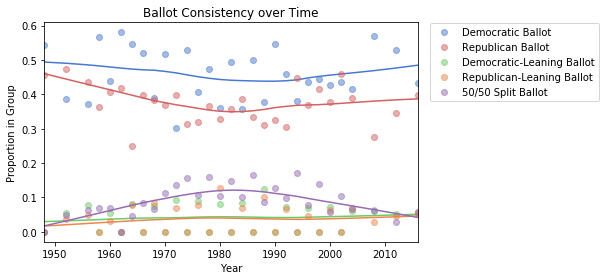

In [9]:
plot_columns_lowess(xtab_norm, columns, color_map)
decorate(xlabel='Year',
         ylabel='Proportion in Group',
         title='Ballot Consistency over Time')

anchor_legend(1.02, 1.02)

# Party Identification vs. Voting Consistency

Then, I'll look at the impact of political identification on voting consistency by looking at the split-ticketedness of different groups of people. Here, I want to look at the correlation between party identification and ticketedness of vote. 

I'll start with Democrats and Republican who identify directly with their parties. The ANES dataset asks for political affiliation and allows respondents to choose between Strong/Weak/Independent affiliation with the Democratic and Republican Party (and Independent).

In [10]:
# Democrats.
strong_democrat_filter = (anes["VCF0301"] == '1. Strong Democrat')
weak_democrat_filter   = (anes["VCF0301"] == '2. Weak Democrat')
strong_democrat_split  = split[strong_democrat_filter]
weak_democrat_split    = split[weak_democrat_filter]
all_democrat_split = pd.concat([strong_democrat_split, weak_democrat_split])

# Republicans.
strong_republican_filter = (anes["VCF0301"] == '7. Strong Republican')
weak_republican_filter   = (anes["VCF0301"] == '6. Weak Republican')
strong_republican_split  = split[strong_republican_filter]
weak_republican_split    = split[weak_republican_filter]
all_republican_split = pd.concat([strong_republican_split, weak_republican_split])


# Independents.
independent_democrat_filter    = (anes["VCF0301"] == '3. Independent - Democrat')
independent_republican_filter  = (anes["VCF0301"] == '5. Independent - Republican')
independent_independent_filter = (anes['VCF0301'] == '4. Independent - Independent')
independet_democrat_splits     = split[independent_democrat_filter]
independent_republican_splits  = split[independent_republican_filter]
independent_independent_splits = split[independent_independent_filter]
all_independent_split = pd.concat([independet_democrat_splits, independent_republican_splits, independent_independent_splits])

I want to be able to look at the correlation between voting records and sticking to expected party-line vote over the years.
### Democrats

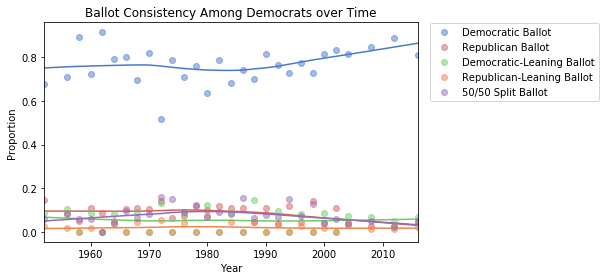

In [11]:
# Crosstabulate and normalize by year.

xtab_norm = pd.crosstab(year, all_democrat_split, normalize='index')
xtab_norm

plot_columns_lowess(xtab_norm, columns, color_map)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Ballot Consistency Among Democrats over Time')

anchor_legend(1.02, 1.02)

### Republicans

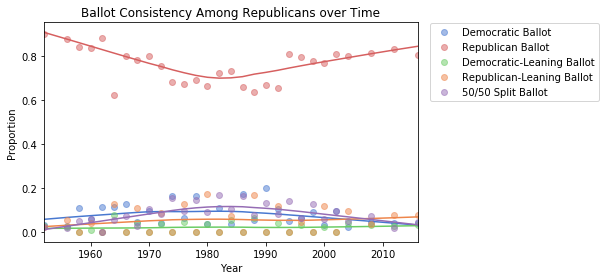

In [12]:
# Crosstabulate and normalize by year.
xtab_norm = pd.crosstab(year, all_republican_split, normalize='index')
xtab_norm

plot_columns_lowess(xtab_norm, columns, color_map)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Ballot Consistency Among Republicans over Time')

anchor_legend(1.02, 1.02)

### Independent Voters

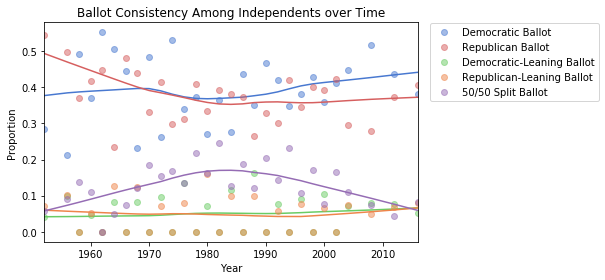

In [13]:
xtab_norm = pd.crosstab(year, all_independent_split, normalize='index')
xtab_norm

plot_columns_lowess(xtab_norm, columns, color_map)
decorate(xlabel='Year',
         ylabel='Proportion',
         title='Ballot Consistency Among Independents over Time')

anchor_legend(1.02, 1.02)